In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Read Images for camera calibration

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')

# Calculating matrix for camera calibration

In [3]:
def cal_undistort(img, gray,objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
    gray.shape[::-1], None, None)
    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx,dist

# Threshoding (Sobel)

In [4]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if (orient=='x'):
        # Take the derivative in x 
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
        # Take the absolute value of the derivative or gradient
        abs_sobelx = np.absolute(sobelx)
        # Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        # Take the derivative in y
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
        # Take the absolute value of the derivative or gradient
        abs_sobely = np.absolute(sobely)
        # Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary_output = np.zeros_like(scaled_sobel)
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

# Magnitude of gradient

In [5]:
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the derivative in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    # Take the derivative in y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

# Direction of gradient

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the derivative in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # Take the derivative in y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Camera calibration, undistortion of image and Gradient calculation

In [7]:
objpoints = []  # To store object ponits for all the images (3d ponits in real world space)
imgpoints = []  # # To store image ponits for all the images (2d points in image plane)
undistort = []
counter = 0
undistort_title = []
draw_chess = []
gray = None
mtx = None
dist = None
gradx = []
grady = []
mag_binary = []
dir_binary = []
ksize = 3
grad_combined = []
img_size = None

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinate

for fname in images:
    
    img = mpimg.imread(fname)
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret,corners = cv2.findChessboardCorners(gray,(9,6), None)
    # Getting image size
    img_size = gray.shape
    # If corners found add points to object and image ponits
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw the corners
        draw_chess.append(cv2.drawChessboardCorners(img,(9,6),corners,ret))
        
#Getting Matrix for camera calibration
mtx,dist = cal_undistort(img,gray,objpoints,imgpoints)

for fname in images:
    
    img = mpimg.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    ret,corners = cv2.findChessboardCorners(gray,(9,6), None)

    if ret == True:
        # image distortion correction
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        undistort.append(undist)
        undistort_title.append(images[counter])
        # Convert undistorted image to gray
        gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
        counter+=1
        
        # Calling Thresholding functions to get binary output
        gradx.append(abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 230)))
        grady.append(abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 230)))
        mag_binary.append(mag_thresh(gray, sobel_kernel=9, mag_thresh=(50, 170)))
        dir_binary.append(dir_threshold(gray, sobel_kernel=15, thresh=(0.3, 1.4)))
    else:
        counter+=1   

# Combining Threshold

In [8]:
for i in range(0,len(gradx)):
    combined = np.zeros_like(dir_binary[i])
    combined[((gradx[i] == 1) & (grady[i] == 1)) | ((mag_binary[i] == 1) & (dir_binary[i] == 1))] = 1
    grad_combined.append(combined)

# Show Plots for Chessboard

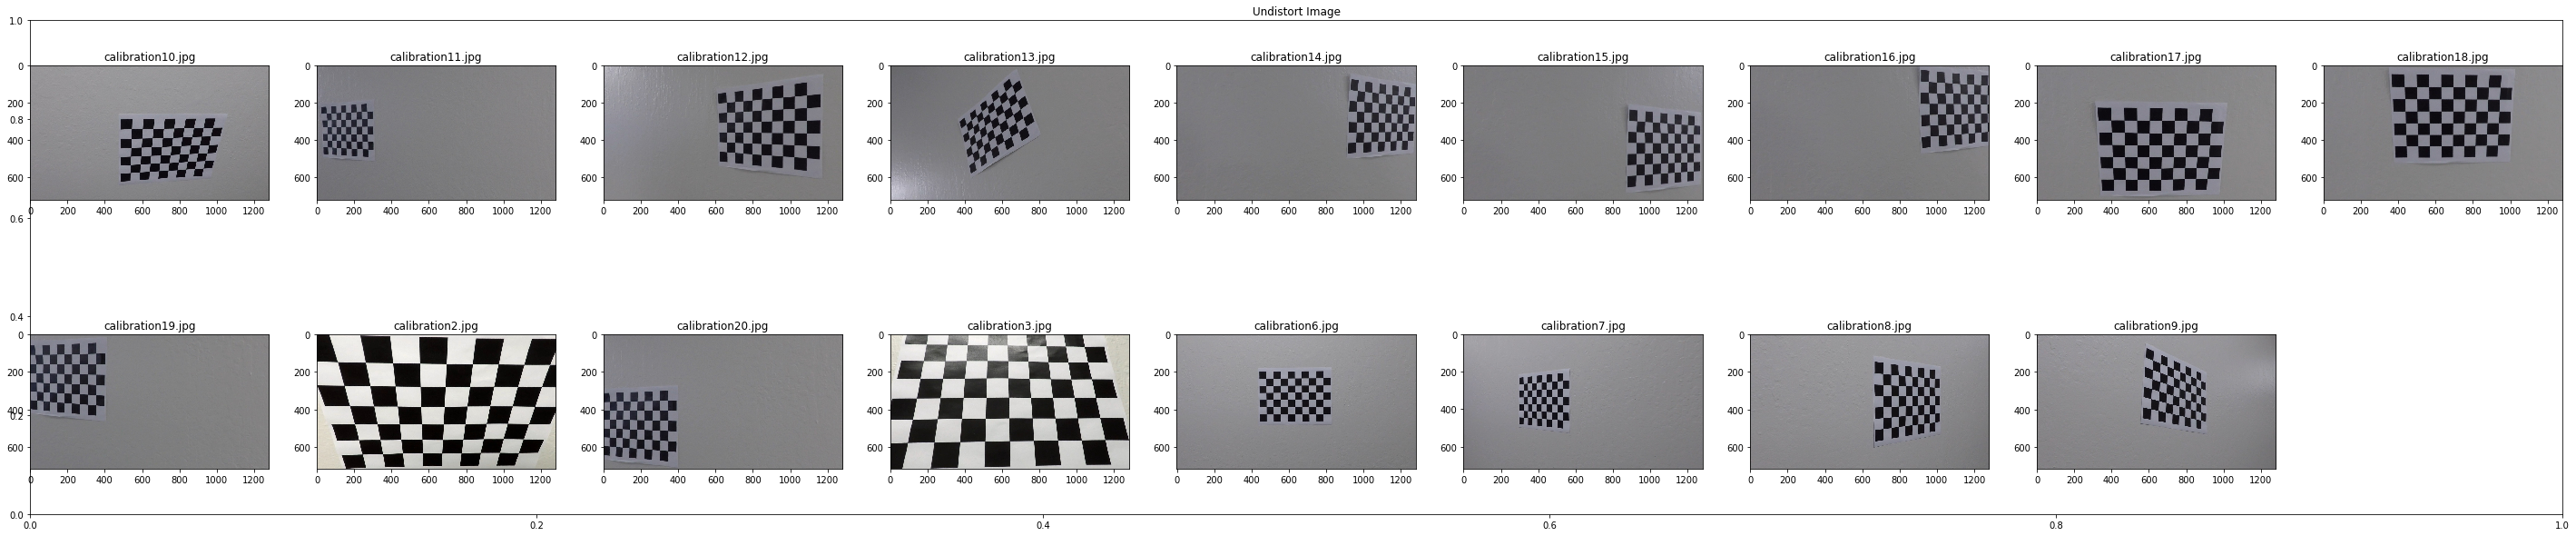

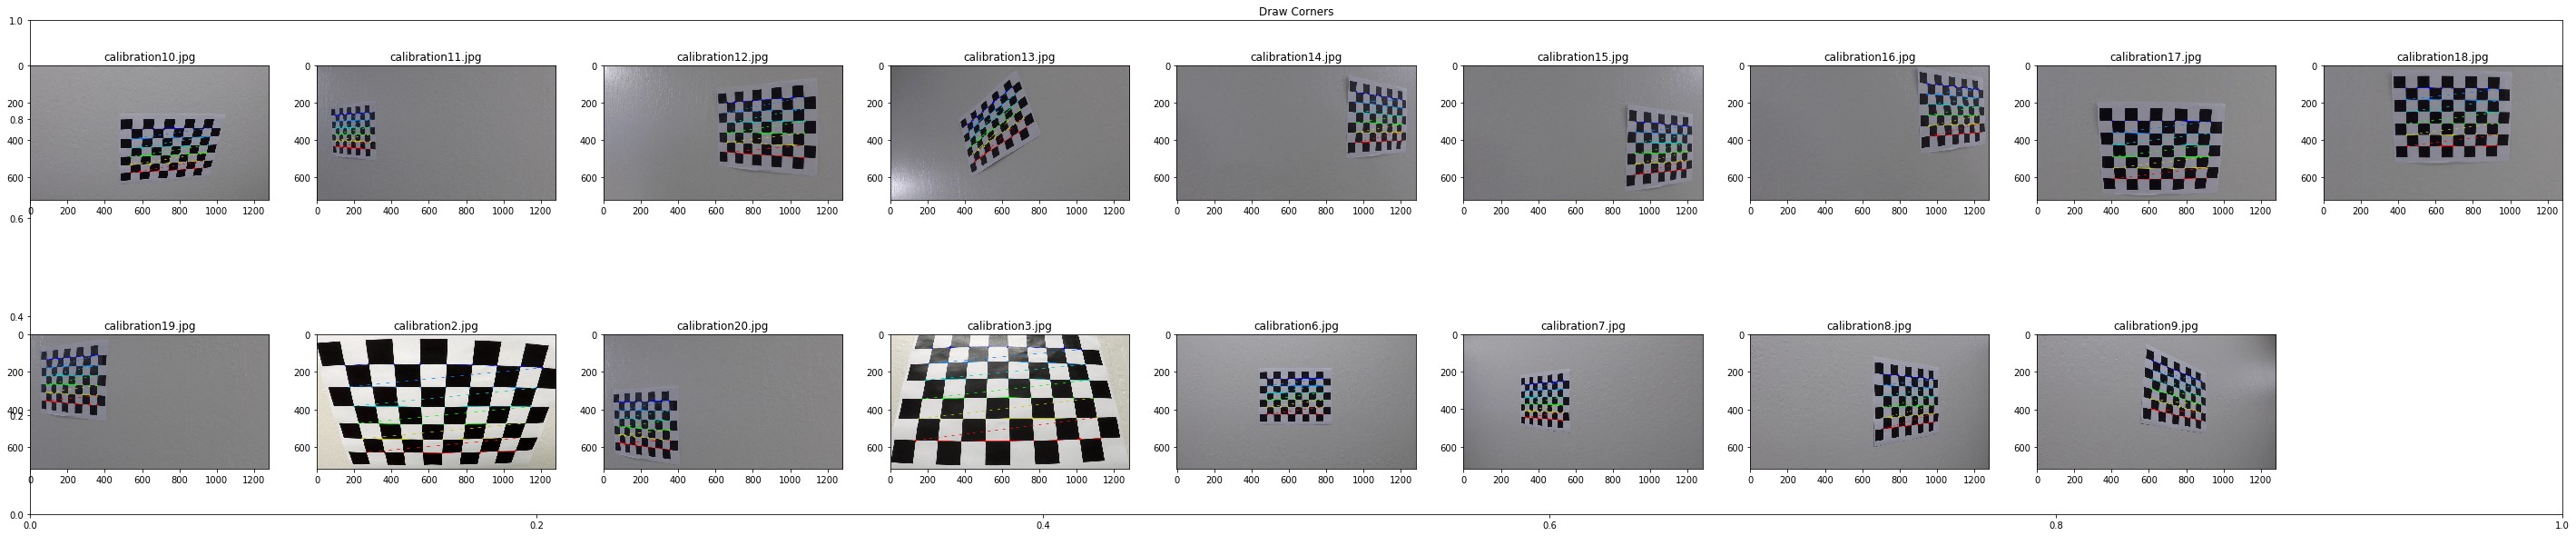

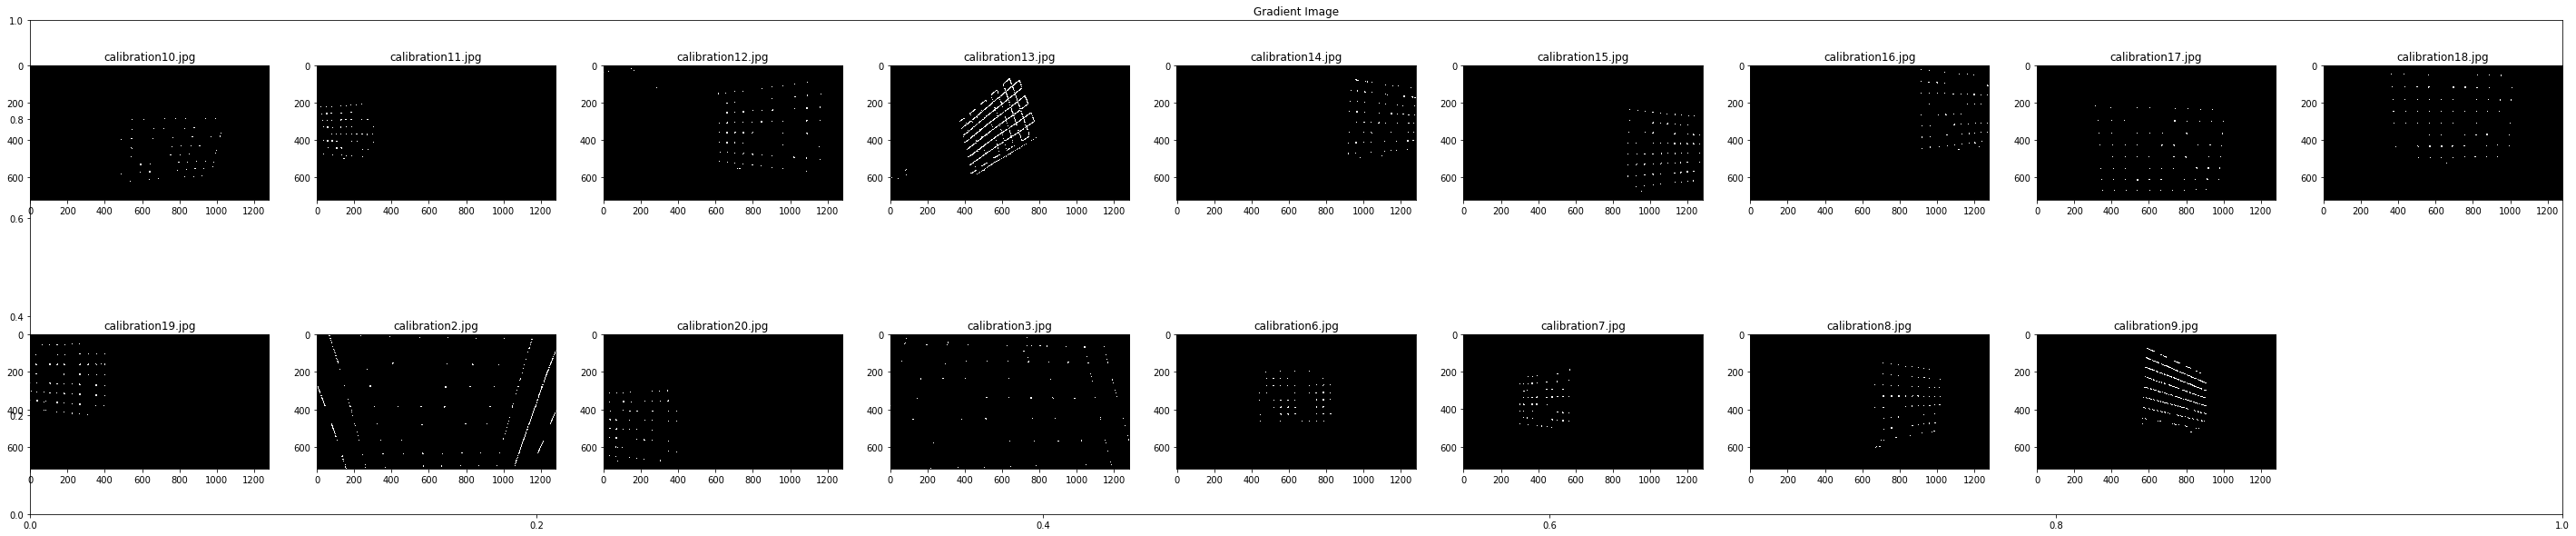

In [9]:
w=100
h=100
fig=plt.figure(figsize=(50, 10))
columns = 9
rows = 2
plt.title("Undistort Image")
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.title(undistort_title[i-1].split('\\')[-1])
    plt.imshow(undistort[i-1])
plt.show()

fig=plt.figure(figsize=(50, 10))
columns = 9
rows = 2
plt.title("Draw Corners")
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.title(undistort_title[i-1].split('\\')[-1])
    plt.imshow(draw_chess[i-1])
plt.show()

fig=plt.figure(figsize=(50, 10))
columns = 9
rows = 2
plt.title("Gradient Image")
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.title(undistort_title[i-1].split('\\')[-1])
    plt.imshow(grad_combined[i-1],cmap='gray')
plt.show()

# Lane Detection

## Read Images

In [10]:
test_images = glob.glob('test_images/test*.jpg')
test_images1 = glob.glob('test_images/straight_lines*.jpg')
for i in test_images1:
    test_images.append(i)

# Perspective Transform

In [11]:
src=np.float32([[239, 683],[571, 455],[751, 455],[1050, 683]])
dst=np.float32([[100, img_size[0]],[100, 0],[img_size[1]-100, 0],[img_size[1]-100, img_size[0]]])
def transform(offset,img_size,img):
    src=np.float32([[239, 683],[571, 455],[751, 455],[1050, 683]])
    dst=np.float32([[100, img_size[0]],[100, 0],[img_size[1]-100, 0],[img_size[1]-100, img_size[0]]])
    source = np.float32([src[0], src[1], src[2], src[3]])
    if(offset==1):
        M = cv2.getPerspectiveTransform(source,dst)
    else:
        M = cv2.getPerspectiveTransform(dst,source)
    # Create warped image using linear interpolation
    warped = cv2.warpPerspective(img, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)
    return warped

## Distortion Correction, Calculating Gradient and combining S-channel and Gradient Threshold

In [12]:
gradx = []
grady = []
counter = 0
mag_binary = []
dir_binary = []
ksize = 3
grad_combined = []
s_channel = []
s_channel_binary = []
combined_binary = []
undistort = []
img_sizes = []
transformed = []
offset = 1  # 1 - src to dst warp and 0 - dst to src warp

for fname in test_images:    
    # Read the image
    img = mpimg.imread(fname)
    # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Extracting S-channel component
    s_channel.append(hls[:,:,2])
    # Finding image size
    img_size = (img.shape[0],img.shape[1])
    img_sizes.append(img_size)
    
    #Undistorting the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undistort.append(undist)
    undistort_title.append(test_images[counter])
    counter+=1
    # Convert undistorted image to gray
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

    # Calling Thresholding functions to get binary output
    gradx.append(abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(70, 150)))
    grady.append(abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(70, 150)))
    mag_binary.append(mag_thresh(gray, sobel_kernel=9, mag_thresh=(100, 170)))
    dir_binary.append(dir_threshold(gray, sobel_kernel=15, thresh=(0.8, 1.2)))
    
# Combining Threshold
for i in range(0,len(gradx)):
    combined = np.zeros_like(dir_binary[i])
    combined[((gradx[i] == 1) & (grady[i] == 1)) | ((mag_binary[i] == 1) & (dir_binary[i] == 1))] = 1
    grad_combined.append(combined)
    

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 240
    s_binary = np.zeros_like(s_channel[i])
    s_binary[(s_channel[i] >= s_thresh_min) & (s_channel[i] <= s_thresh_max)] = 1
    s_channel_binary.append(s_binary)

#Combining with color threshold
for i in range(0,len(gradx)):
    binary = np.zeros_like(grad_combined[i])
    binary[(s_channel_binary[i] == 1) | (grad_combined[i] == 1)] = 1
    combined_binary.append(binary)

# Calling Perspective Transform Function

In [13]:
for i in range(0,len(img_sizes)):
    transformed.append(transform(1,img_sizes[i],combined_binary[i]))

# Show plots for test images

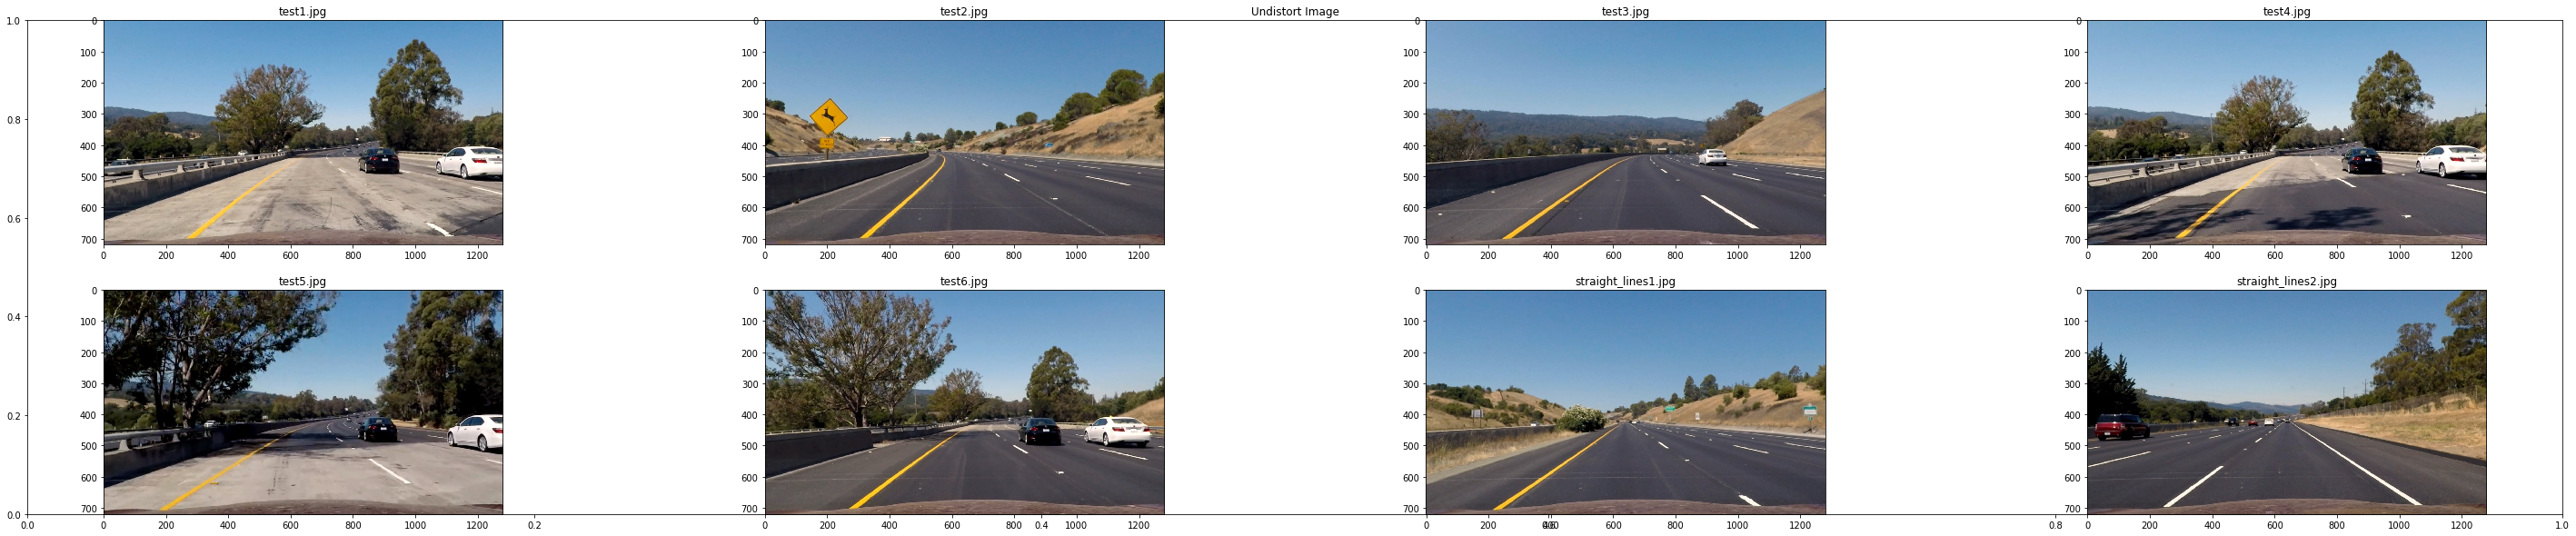

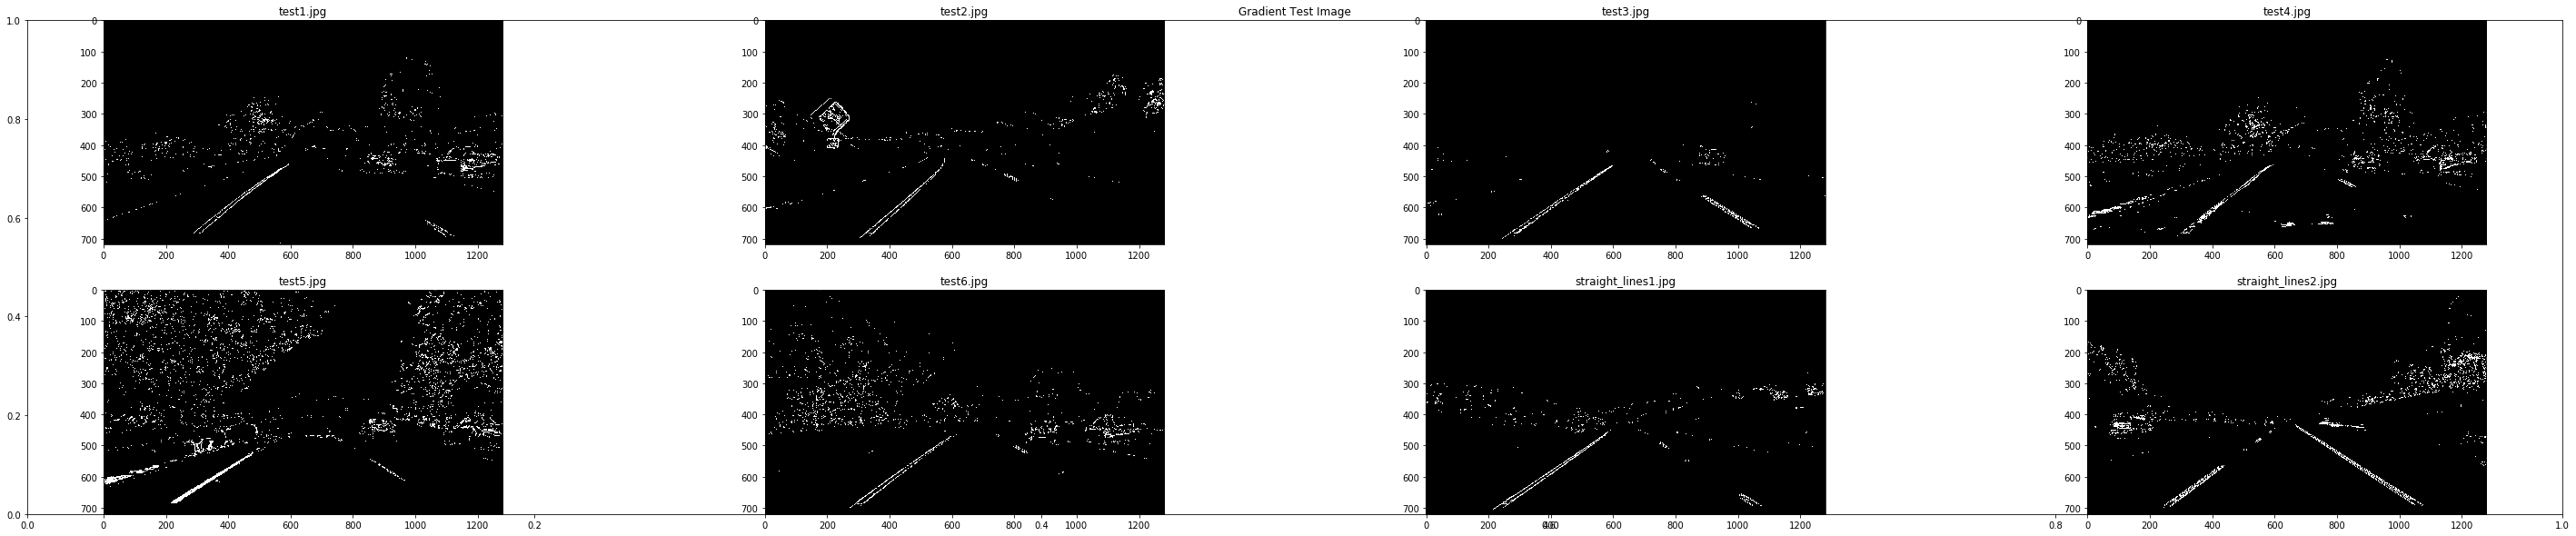

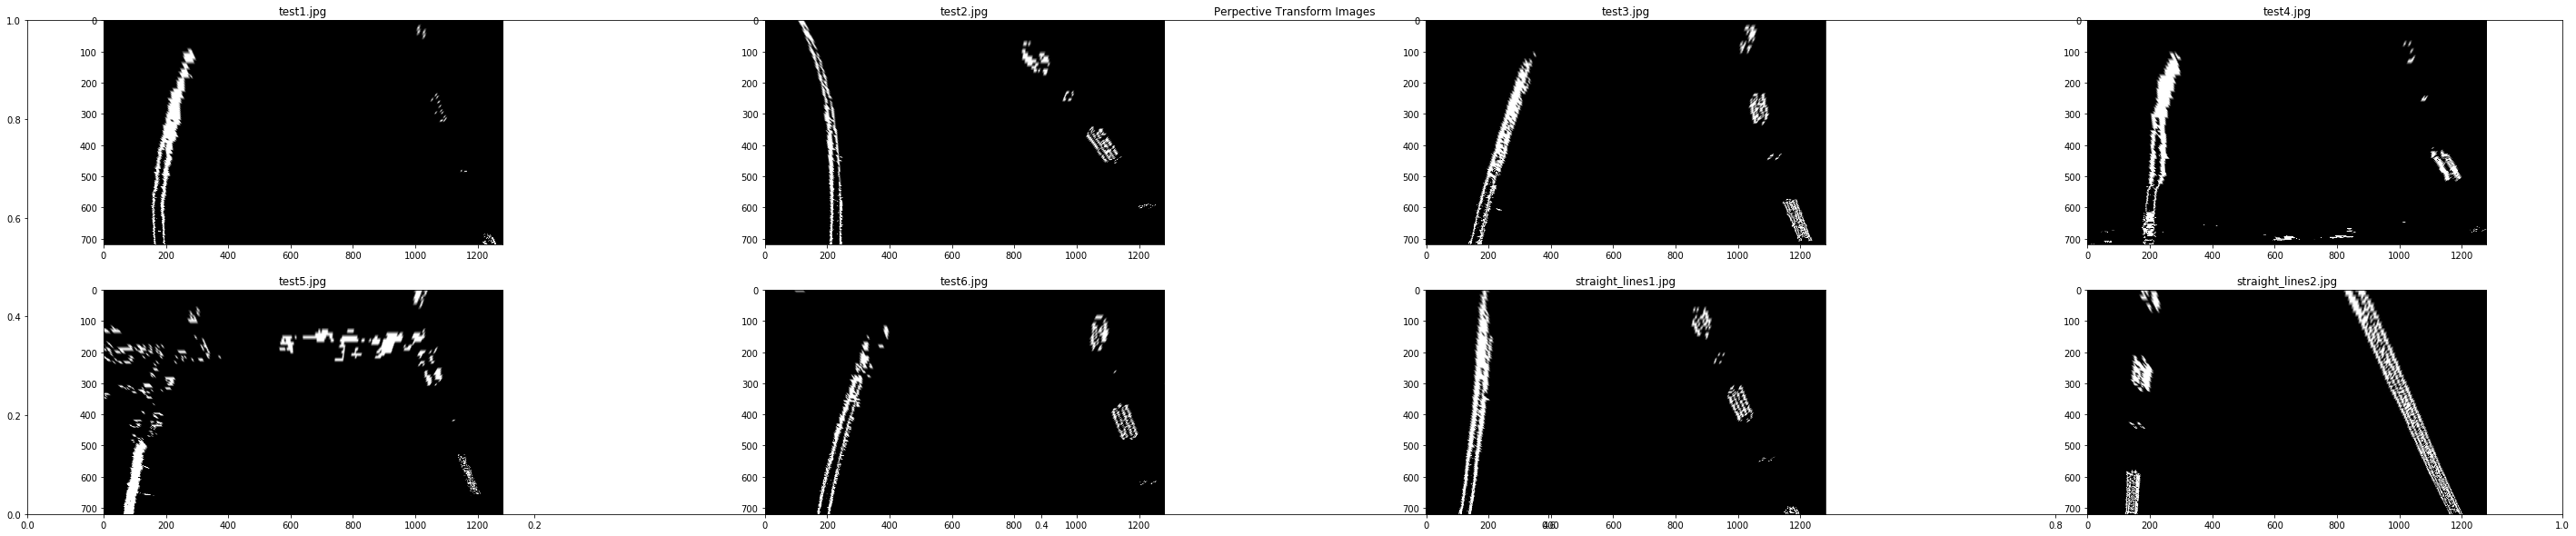

In [14]:
w=100
h=100
fig=plt.figure(figsize=(50, 10))
columns = 4
rows = 2
plt.title("Undistort Image")
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.title(test_images[i-1].split('\\')[-1])
    plt.imshow(undistort[i-1])
plt.show()

fig=plt.figure(figsize=(50, 10))
columns = 4
rows = 2
plt.title("Gradient Test Image")
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.title(test_images[i-1].split('\\')[-1])
    plt.imshow(combined_binary[i-1],cmap='gray')
plt.show()

fig=plt.figure(figsize=(50, 10))
columns = 4
rows = 2
plt.title("Perpective Transform Images")
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.title(test_images[i-1].split('\\')[-1])
    plt.imshow(transformed[i-1],cmap='gray')
plt.show()

# Copy distorted image to new list

In [15]:
new_undistort = np.copy(undistort)

# Function to draw ROI

In [16]:
def draw_roi(img,src):
   x1,y1=src[0][0],src[0][1]
   x2,y2=src[1][0],src[1][1]
   x3,y3=src[2][0],src[2][1]
   x4,y4=src[3][0],src[3][1]
   
   cv2.line(img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(255,0,0),5)
   cv2.line(img,(src[1][0],src[1][1]),(src[2][0],src[2][1]),(255,0,0),5)
   cv2.line(img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(255,0,0),5)
   return img

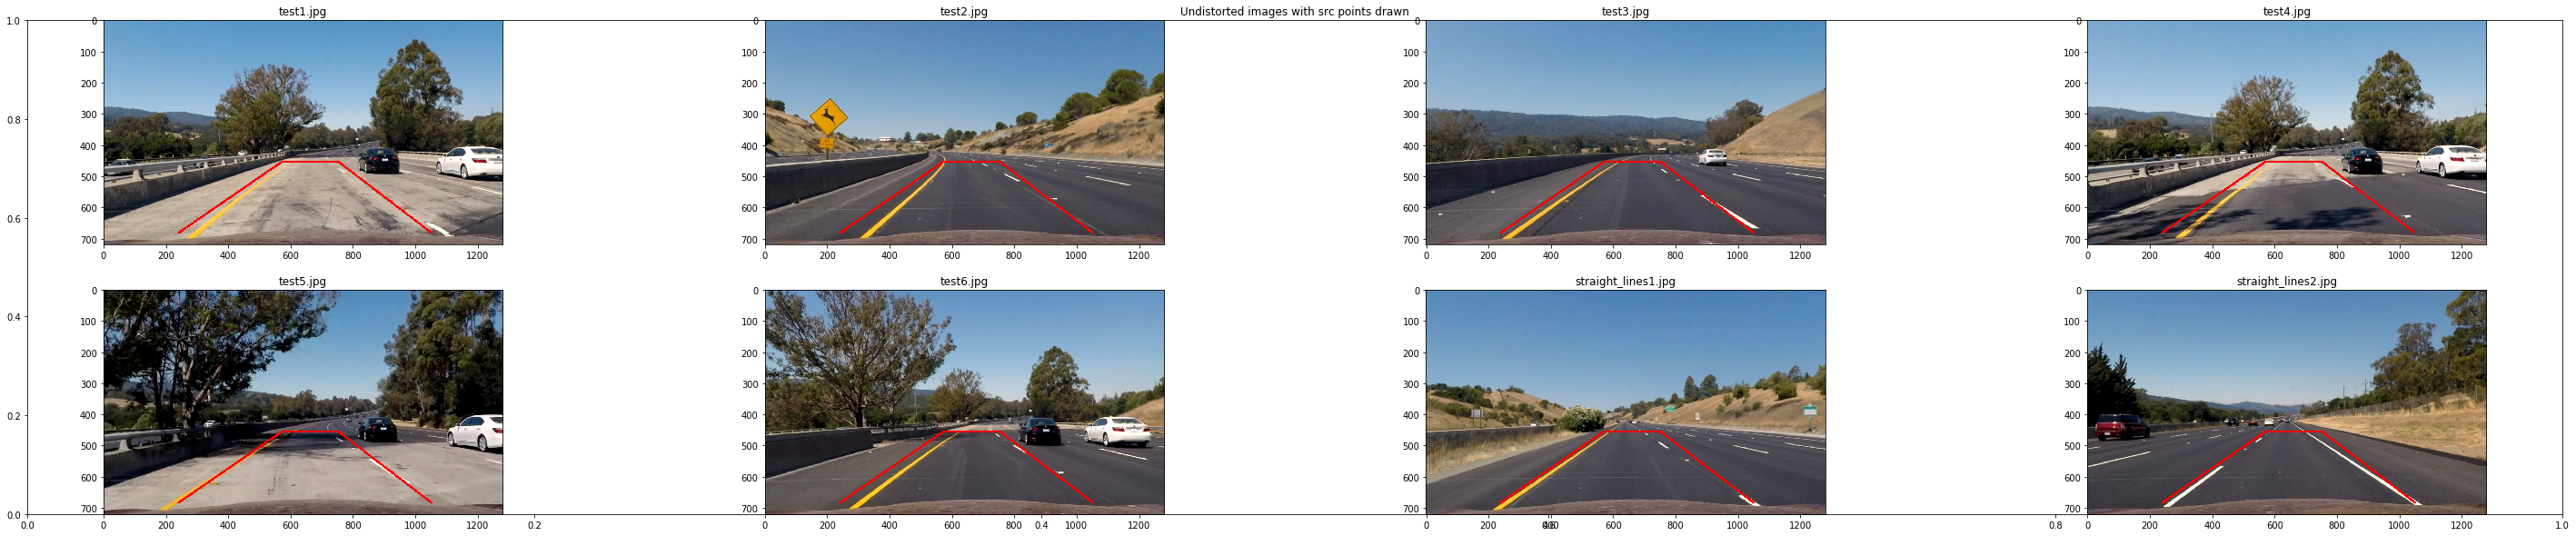

In [17]:
roi_image = []

fig=plt.figure(figsize=(50, 10))
columns = 4
rows = 2
plt.title("Undistorted images with src points drawn")
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.title(test_images[i-1].split('\\')[-1])
    img_binary=draw_roi(new_undistort[i-1],np.int32(src))
    plt.imshow(img_binary)
    roi_image.append(img_binary)
plt.show()

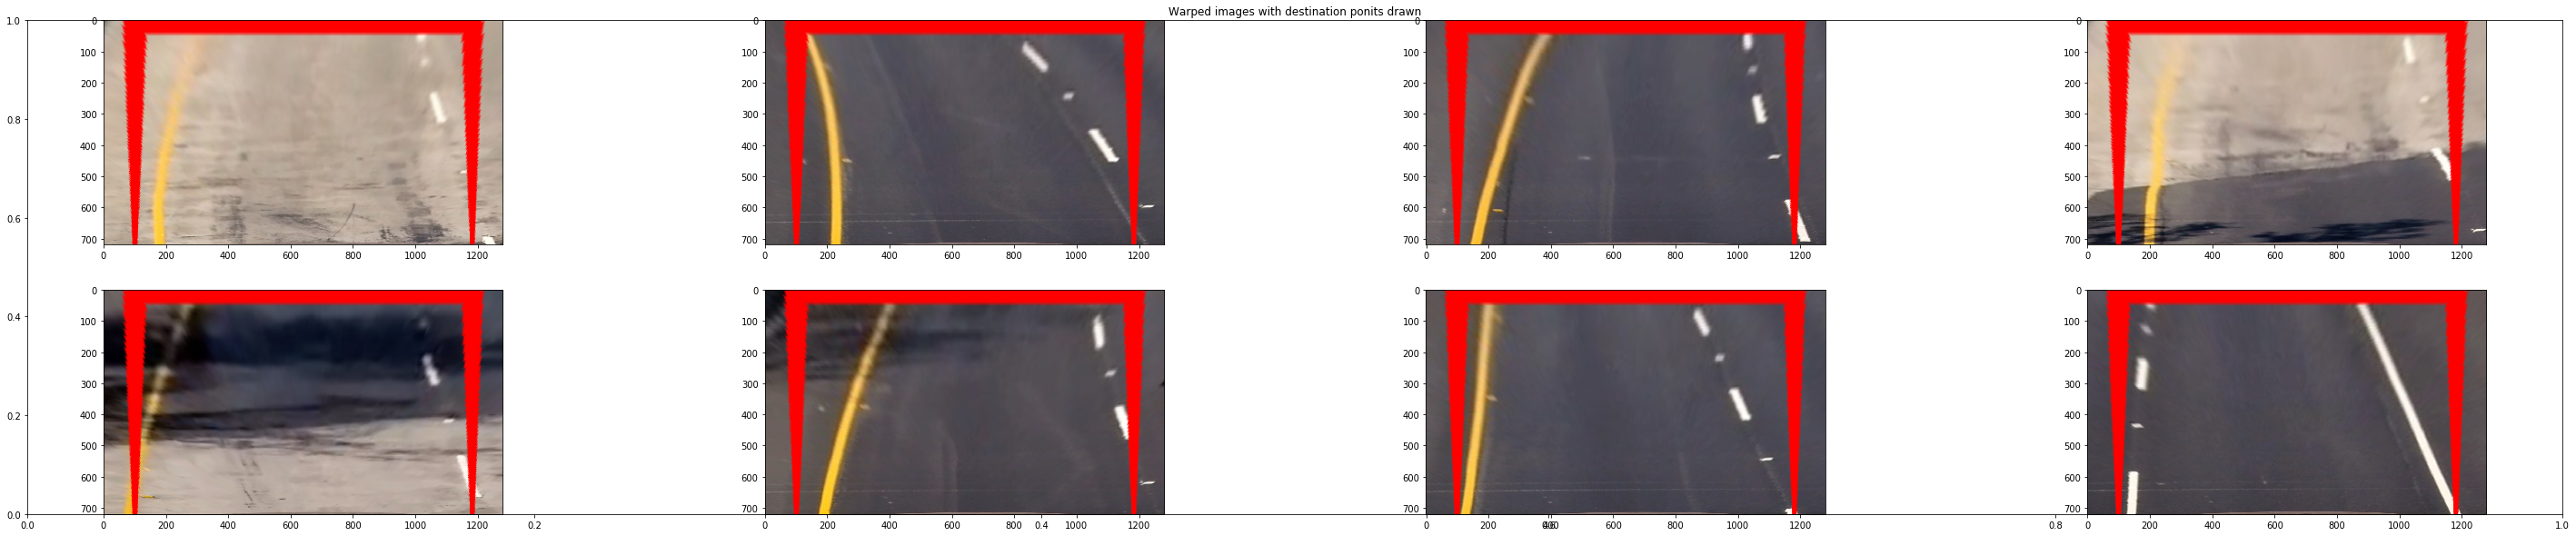

In [18]:
M = cv2.getPerspectiveTransform(src, dst)
       # Warp the image using OpenCV warpPerspective()
img_size=(img.shape[1],img.shape[0])

fig=plt.figure(figsize=(50, 10))
columns = 4
rows = 2
plt.title("Warped images with destination ponits drawn")
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    warped = cv2.warpPerspective(roi_image[i-1], M, img_size)
    plt.imshow(warped)
plt.show()

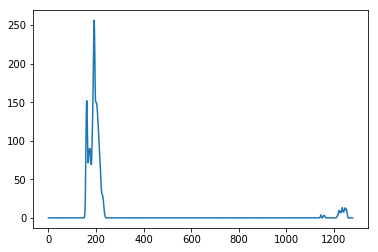

In [19]:
import numpy as np
histogram = np.sum(transformed[0][transformed[0].shape[0]//2:,:], axis=0)
plt.plot(histogram)


In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque 
left_fitx = None
right_fitx = None
left_fit = None
right_fit = None
ploty = None

# For deque
avg_left = deque(maxlen=10)
avg_right = deque(maxlen=10)



def window(binary_warped): 
     # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Running average
    ##
    avg_left.append(left_fit)
    avg_right.append(right_fit)
    a = np.average(avg_left,axis=0)
    b = np.average(avg_right,axis=0)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = a[0]*ploty**2 + a[1]*ploty + a[2]
    right_fitx = b[0]*ploty**2 + b[1]*ploty + b[2]
    ##


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Coloring the area
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    pts = np.hstack((pts_left, pts_right))
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
  # Draw the lane onto the warped blank image
    full = cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    #curvature
    #pixel to meter
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculating center
    l_fit = left_fit
    r_fit = right_fit
    h = image.shape[0]
    if right_fit is not None and left_fit is not None:
        car_position = image.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    #print('car center',center_dist)

    return full,left_curverad,right_curverad,center_dist

# Draw Center and radius on image

In [21]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of curve: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

# Pipeline

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
def process_image(image):
    img_size = (image.shape[0],image.shape[1])
    #Undistorting the image
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # Convert undistorted image to gray
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

    # Calling Thresholding functions to get binary output
    gradx=(abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(70, 150)))
    grady=(abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(70, 150)))
    mag_binary=(mag_thresh(gray, sobel_kernel=9, mag_thresh=(100, 170)))
    dir_binary=(dir_threshold(gray, sobel_kernel=15, thresh=(0.8, 1.2)))

    # Combining Threshold
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Extracting S-channel component
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 240
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combining with color threshold
    binary = np.zeros_like(combined)
    binary[(s_binary== 1) | (combined == 1)] = 1
    
    # Perspective Transform
    transformed = (transform(1,img_size,binary))

    # Sliding window, Radius and center
    sliding,left_curve,right_curve,center = window(transformed)
 
    # Unwarp the sliding window image 
    unwrap = transform(0,img_size,sliding)
    
    # Overlaying the original and unwarp image
    result = cv2.addWeighted(image, 1, unwrap, 0.3, 0)
    
    # Draw result of radius and center on image
    final = draw_data(result,(left_curve+right_curve)/2,center)
    
    return final


# Running pipeline for test image

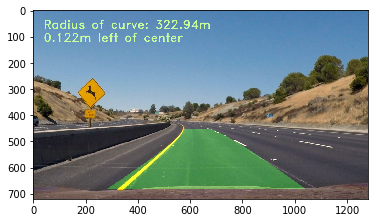

In [23]:
image=plt.imread('test_images/test2.jpg')
a=process_image(image)
plt.imshow(a)

In [24]:
import cv2
import matplotlib.pyplot as plt

# Creating a Video capture object
cap = cv2.VideoCapture('D:/CarND-Advanced-Lane-Lines-master/project_video.mp4')

# Getting width and height of frame
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Creating a Video writer object
out = cv2.VideoWriter('D:/CarND-Advanced-Lane-Lines-master/outpy.mp4',cv2.VideoWriter_fourcc(*'XVID'), 10,(frame_width,frame_height))

while 1:
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        out_frame = process_image(frame)
        out.write(np.uint8(out_frame))
  # Break the loop
    else: 
        break

# Release all resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("done")


done
